In [149]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import re
from datetime import date
import sys
import datetime as dt

local_tmp = 'tmp'

In [123]:
# read the games from S3
os.system(f'mkdir {local_tmp}')
os.system(f'aws s3 sync s3://b-shelton-sports/nba/games {local_tmp}')
games = pd.concat(map(pd.read_csv, glob.glob(f'{local_tmp}/*.gz')))
os.system(f'rm -r {local_tmp}')

# convert start_date to date format
games['start_date'] = pd.to_datetime(games['start_date'].astype('str').str.split("T").str[0])

print(games.shape)
print(games.columns)
print(games.start_date.min())
print(games.start_date.max())

(7258, 13)
Index(['game_id', 'season_type', 'start_date', 'venue_id', 'attendance',
       'completed', 'conference_comp', 'neutral_site', 'broadcast_market',
       'broadcast_network', 'pbp_link', 'boxscore_link', 'date'],
      dtype='object')
2014-10-29 00:00:00
2020-10-11 00:00:00


In [124]:
games.head()

,game_id,season_type,start_date,venue_id,attendance,completed,conference_comp,neutral_site,broadcast_market,broadcast_network,pbp_link,boxscore_link,date
0,401160877,2,2019-11-24,1394,18055,True,False,False,away,FSSW,http://www.espn.com/nba/playbyplay?gameId=4011...,http://www.espn.com/nba/boxscore?gameId=401160877,2019-11-24T20:30Z
1,401160878,2,2019-11-24,1830,18770,True,False,False,away,YES,http://www.espn.com/nba/playbyplay?gameId=4011...,http://www.espn.com/nba/boxscore?gameId=401160878,2019-11-24T23:00Z
2,401160879,2,2019-11-24,1823,15885,True,False,False,away,CSAC,http://www.espn.com/nba/playbyplay?gameId=4011...,http://www.espn.com/nba/boxscore?gameId=401160879,2019-11-24T23:00Z
3,401160880,2,2019-11-25,892,19520,True,False,False,home,ALT,http://www.espn.com/nba/playbyplay?gameId=4011...,http://www.espn.com/nba/boxscore?gameId=401160880,2019-11-25T01:00Z
4,401160881,2,2019-11-25,1841,19068,True,False,False,away,FSN,http://www.espn.com/nba/playbyplay?gameId=4011...,http://www.espn.com/nba/boxscore?gameId=401160881,2019-11-25T02:00Z


In [125]:
# read the opponents from S3
os.system(f'mkdir {local_tmp}')
os.system(f'aws s3 sync s3://b-shelton-sports/nba/opponents {local_tmp}')
opp = pd.concat(map(pd.read_csv, glob.glob(f'{local_tmp}/*.gz')))
os.system(f'rm -r {local_tmp}')
opp.shape

(14668, 11)

In [126]:
opp.head()

,game_id,team_id,team,team_abbr,home_away,winner,final_points,q1_points,q2_points,q3_points,q4_points
0,400974929,3,Pelicans,NO,home,True,111,31.0,32.0,25.0,23.0
1,400974929,12,Clippers,LAC,away,False,103,26.0,32.0,24.0,21.0
2,400974928,27,Wizards,WSH,home,True,113,20.0,29.0,27.0,37.0
3,400974928,1,Hawks,ATL,away,False,94,19.0,23.0,25.0,27.0
4,400974931,10,Rockets,HOU,home,True,111,33.0,29.0,31.0,18.0


In [127]:
# read the box scores from S3
os.system(f'mkdir {local_tmp}')
os.system(f'aws s3 sync s3://b-shelton-sports/nba/boxscores {local_tmp}')
box = pd.concat(map(pd.read_csv, glob.glob(f'{local_tmp}/*.gz')))
os.system(f'rm -r {local_tmp}')
box.shape

(186815, 19)

In [128]:
box.head()

,game_id,team,player_uid,player_name,player_pos,min,fg,three_pt,ft,oreb,dreb,reb,ast,stl,blk,to,pf,plusminus,pts
0,401161499,Hornets,s:40~l:46~a:4278078,P. Washington,PF,25,3-9,3-6,0-2,2,1,3,2,0,0,2,1,-33,NaN
1,401161499,Hornets,s:40~l:46~a:4066383,M. Bridges,SF,26,7-16,2-6,1-1,1,5,6,1,1,0,0,0,-23,NaN
2,401161499,Hornets,s:40~l:46~a:2579258,C. Zeller,C,24,4-9,0-1,1-4,2,2,4,2,1,0,1,1,-27,NaN
3,401161499,Hornets,s:40~l:46~a:3074752,T. Rozier,PG,26,2-13,1-4,0-0,0,3,3,7,0,0,1,0,-27,NaN
4,401161499,Hornets,s:40~l:46~a:4066262,M. Monk,SG,27,4-13,0-4,0-0,1,0,1,3,1,0,0,2,-33,NaN


In [129]:
# Get rid of games not involving one of the 30 NBA teams
removals = opp[~opp['team_id'].isin(np.arange(1, 31))]
remove_games = removals['game_id'].unique()
games = games[~games['game_id'].isin(remove_games)]
opp = opp[~opp['game_id'].isin(remove_games)]
box = box[~box['game_id'].isin(remove_games)]
display(f'Games removed because they involve a team other than one of the 30 NBA teams: {remove_games.shape[0]}')
#remaining teams
opp.groupby(['team_id','team']).size().reset_index()

# Keep only completed games
games = games[games['completed'] == True]
# Get rid of unnecessary fields
games = games.drop(['pbp_link', 'boxscore_link'], axis = 1)

'Games removed because they involve a team other than one of the 30 NBA teams: 15'

In [130]:
box.groupby('pts').game_id.count().reset_index().sort_values('game_id', ascending = False).head(10)

,pts,game_id
0,0,39448
2,2,9991
4,4,7871
6,6,7804
8,8,7054
5,5,6243
10,10,6180
3,3,5754
7,7,5742
9,9,5646


In [131]:
box.iloc[0]['pts']

nan

In [132]:
# find out how many player records have a null pts value
print(box[box['pts'].isnull()].shape[0])
print(box[box['pts'].isnull()].shape[0] / box.shape[0])

13831
0.07420940239727865


In [133]:
# see the split of the different game types
# season_type == 2 is the regular season
games.groupby('season_type')['game_id'].count()

season_type
1       1
2    6825
3     414
5       1
Name: game_id, dtype: int64

In [134]:
reg_games = games[games['season_type'] == 2].reset_index(drop = True)
reg_opp = opp[opp['game_id'].isin(reg_games['game_id'].tolist())].reset_index(drop = True)
print(reg_games.shape)
print(reg_opp.shape)

(6825, 11)
(13650, 11)


In [135]:
# make sure that every regular season game has a home team and away team
print(reg_opp[reg_opp['home_away'] == 'home'].shape[0] / reg_opp.shape[0])
print(reg_opp[reg_opp['home_away'] == 'away'].shape[0] / reg_opp.shape[0])

0.5
0.5


In [173]:
# cast the home and away points against each other then create final points spread
reg_opp['final_points'] = pd.to_numeric(reg_opp['final_points'])
reg_opp2 = reg_opp.pivot_table(index = ['game_id'], 
                               columns = 'home_away', 
                               values = 'final_points').reset_index()
reg_opp2.columns = ['game_id', 'away_pts', 'home_pts']
reg_opp2['spread'] = reg_opp2['home_pts'] - reg_opp2['away_pts']

reg_opp3 = reg_opp.pivot_table(index = ['game_id'], 
                               columns = 'home_away', 
                               values = 'team_abbr',
                               aggfunc=lambda x: ' '.join(x)).reset_index()
reg_opp3.columns = ['game_id', 'away_team', 'home_team']

reg_opp4 = pd.merge(reg_opp2, reg_opp3, on = 'game_id', how = 'inner')
final = pd.merge(reg_opp4, games, on = 'game_id', how = 'inner')
final.head()

,game_id,away_pts,home_pts,spread,away_team,home_team,season_type,start_date,venue_id,attendance,completed,conference_comp,neutral_site,broadcast_market,broadcast_network,date
0,400578293,84,101,17,ORL,NO,2,2014-10-29,985,17097,True,False,False,home,FSN,2014-10-29T00:00Z
1,400578294,100,101,1,DAL,SA,2,2014-10-29,780,19615,True,False,False,national,TNT,2014-10-29T00:00Z
2,400578295,108,90,-18,HOU,LAL,2,2014-10-29,1841,18997,True,False,False,national,TNT,2014-10-29T02:30Z
3,400578296,106,108,2,MIL,CHA,2,2014-10-29,1893,19439,True,False,False,away,FSWI,2014-10-29T23:00Z
4,400578297,91,103,12,PHI,IND,2,2014-10-29,2183,18165,True,False,False,home,FSMW,2014-10-29T23:00Z


## Explore the Point Spread (Label)

Text(0.5, 1.0, 'Distribution of Home Team Point Spread')

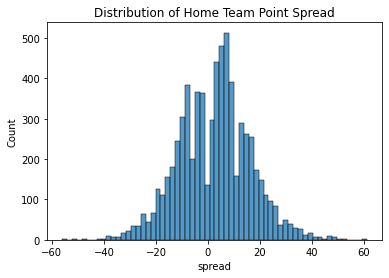

In [157]:
sns.histplot(x = final['spread']).set_title('Distribution of Home Team Point Spread')

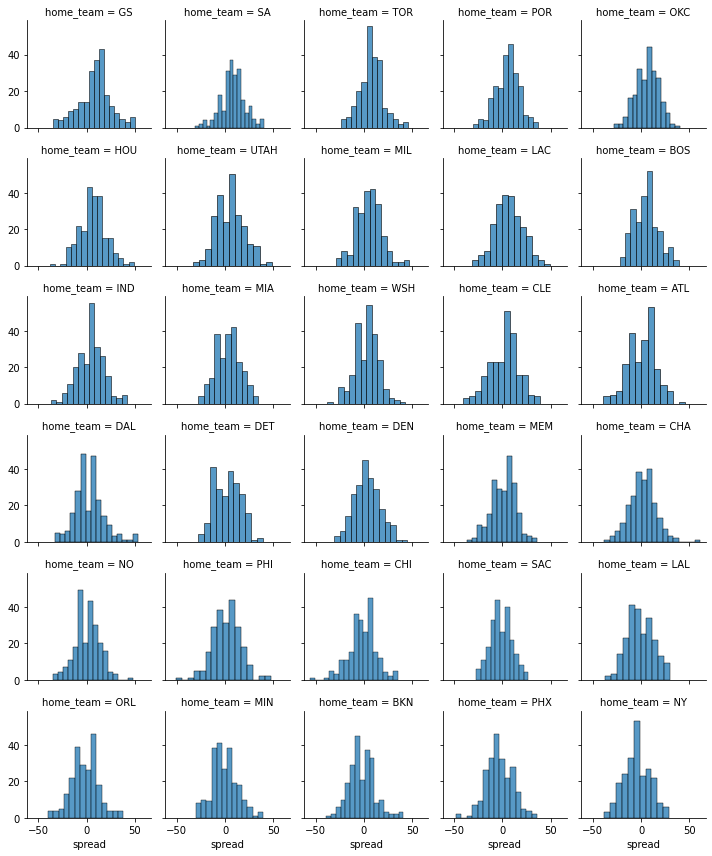

In [178]:
# spread by home team
median_order = final.groupby('home_team').agg({'spread': 'median'}).reset_index() \
    .sort_values('spread', ascending = False)['home_team'].to_list()
g = sns.FacetGrid(final, col = 'home_team', height=2, col_wrap =5, col_order = median_order)
g.map(sns.histplot, 'spread')

In [138]:
final['spread'].describe()

count    6825.000000
mean        2.503883
std        13.802249
min       -56.000000
25%        -7.000000
50%         4.000000
75%        11.000000
max        61.000000
Name: spread, dtype: float64

Text(0.5, 1.0, 'Home Team Spread Averages by Game Date')

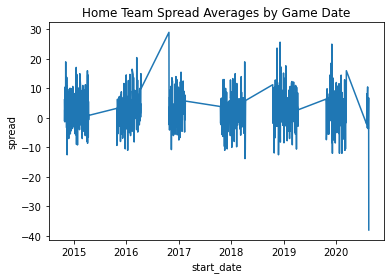

In [159]:
# See if the home team spread averages has changed over the years
spread_by_date = final.groupby('start_date').agg({'spread': 'mean'}).reset_index()
sns.lineplot(data=spread_by_date, x="start_date", y="spread").set_title('Home Team Spread Averages by Game Date')

### Develop the Baseline Model
Consisting of the average points of the home team over their last 10 games minus the average points of the away team over their last five games

In [254]:
opp.head()

,game_id,team_id,team,team_abbr,home_away,winner,final_points,q1_points,q2_points,q3_points,q4_points
0,400974929,3,Pelicans,NO,home,True,111,31.0,32.0,25.0,23.0
1,400974929,12,Clippers,LAC,away,False,103,26.0,32.0,24.0,21.0
2,400974928,27,Wizards,WSH,home,True,113,20.0,29.0,27.0,37.0
3,400974928,1,Hawks,ATL,away,False,94,19.0,23.0,25.0,27.0
4,400974931,10,Rockets,HOU,home,True,111,33.0,29.0,31.0,18.0


In [258]:
reg_opp2.head()

,game_id,away_pts,home_pts,spread
0,400578293,84,101,17
1,400578294,100,101,1
2,400578295,108,90,-18
3,400578296,106,108,2
4,400578297,91,103,12


In [259]:
# sort each team by game date
team_date = pd.merge(reg_games[['game_id', 'start_date']],
                     reg_opp[['game_id', 'team_abbr', 'final_points']],
                     on = 'game_id', how = 'inner')

team_date = team_date.sort_values(['team_abbr', 'start_date'])

# get the average for the five previous games
x = 10
team_date[f'last_{x}_avg'] = team_date.groupby(['team_abbr']) \
    .shift(1).rolling(x).final_points.mean()

team_date.head(15)

,game_id,start_date,team_abbr,final_points,last_10_avg
5057,400578300,2014-10-29,ATL,102,NaN
6588,400578324,2014-11-01,ATL,102,NaN
10861,400578356,2014-11-06,ATL,92,NaN
4529,400578363,2014-11-08,ATL,119,NaN
8544,400578376,2014-11-09,ATL,103,NaN
9147,400578392,2014-11-11,ATL,91,NaN
13522,400578402,2014-11-13,ATL,100,NaN
8372,400578416,2014-11-15,ATL,114,NaN
2071,400578425,2014-11-16,ATL,94,NaN
1690,400578447,2014-11-19,ATL,109,NaN


In [265]:
# merge home teams to final to form baseline table
bl_final = pd.merge(final[['game_id', 'home_team', 'away_team', 'home_pts', 'away_pts', 'spread', 'start_date', 'season_type']], 
                    team_date[['game_id', 'team_abbr', f'last_{x}_avg']], 
                    left_on = ['game_id', 'home_team'], 
                    right_on = ['game_id', 'team_abbr'],
                    how = 'inner') \
    .drop('team_abbr', 1) \
    .rename({f'last_{x}_avg': f'last_{x}_home'}, axis=1)

bl_final = pd.merge(bl_final, 
                    team_date[['game_id', 'team_abbr', f'last_{x}_avg']], 
                    left_on = ['game_id', 'away_team'], 
                    right_on = ['game_id', 'team_abbr'],
                    how = 'inner') \
    .drop('team_abbr', 1) \
    .rename({f'last_{x}_avg': f'last_{x}_away'}, axis=1)

bl_final['pred'] = bl_final[f'last_{x}_home'] - bl_final[f'last_{x}_away']
bl_final['diff'] = bl_final['pred'] - bl_final['spread']

In [266]:
bl_mae = np.mean(np.abs(bl_final['diff']))
bl_mae

11.377771111444428

Text(0.5, 1.0, 'Distribution of Baseline Spread Errors')

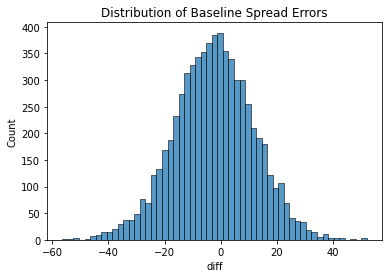

In [267]:
sns.histplot(x = bl_final['diff']).set_title('Distribution of Baseline Spread Errors')

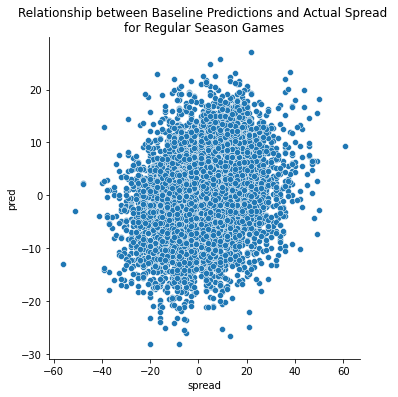

In [268]:
sns.relplot(x = bl_final['spread'], y = bl_final['pred']) \
    .set(title = 'Relationship between Baseline Predictions and Actual Spread \nfor Regular Season Games')

In [270]:
bl_final.sort_values('start_date', ascending = False).head()

,game_id,home_team,away_team,home_pts,away_pts,spread,start_date,season_type,last_10_home,last_10_away,pred,diff
6821,401224790,HOU,PHI,96,134,-38,2020-08-15,2,114.8,119.0,-4.2,33.8
6824,401224793,TOR,DEN,117,109,8,2020-08-14,2,111.0,114.7,-3.7,-11.7
6823,401224792,LAC,OKC,107,103,4,2020-08-14,2,118.8,110.3,8.5,4.5
6822,401224791,IND,MIA,109,92,17,2020-08-14,2,110.4,109.9,0.5,-16.5
6818,401224787,ORL,NO,133,127,6,2020-08-14,2,116.2,113.1,3.1,-2.9
